# Diversity vs. Similarity

This notebook examines two ways of measuring diversity. The first is the diversity
metric from the `divintseg` package. This measures the probability of a person living
in an area encountering a person from a different racial or ethnic group. The second is 
similarity to the overall United States population. Under this measure, areas whose 
distribution of racial and ethnic groups closely resembles that of the country as a whole
score highest. Support for computing similarity was recently added to `divintseg`.

# 0. Imports and configuration

In [1]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC, AK, NJ
from censusdis import states

import divintseg as dis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import itertools

In [2]:
# Fill in your own key here, or leave as is
# if you are doing low volume queries that
# will not hit the census server usage limits.
CENSUS_API_KEY = None

# 1. Identify the dataset and variables we will use

In [3]:
DATASET = "acs/acs5"
YEAR = 2020

In [4]:
GROUP = "B03002"

HISPANIC_LATINO_VARIABLE = f'{GROUP}_012E'

In [5]:
df_variables = ced.variables.all_variables(DATASET, YEAR, GROUP)
df_variables

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2020,acs/acs5,B03002,B03002_001E,Estimate!!Total:,NaN,None
1,2020,acs/acs5,B03002,B03002_002E,Estimate!!Total:!!Not Hispanic or Latino:,NaN,None
2,2020,acs/acs5,B03002,B03002_003E,Estimate!!Total:!!Not Hispanic or Latino:!!Whi...,NaN,None
3,2020,acs/acs5,B03002,B03002_004E,Estimate!!Total:!!Not Hispanic or Latino:!!Bla...,NaN,None
4,2020,acs/acs5,B03002,B03002_005E,Estimate!!Total:!!Not Hispanic or Latino:!!Ame...,NaN,None
5,2020,acs/acs5,B03002,B03002_006E,Estimate!!Total:!!Not Hispanic or Latino:!!Asi...,NaN,None
6,2020,acs/acs5,B03002,B03002_007E,Estimate!!Total:!!Not Hispanic or Latino:!!Nat...,NaN,None
7,2020,acs/acs5,B03002,B03002_008E,Estimate!!Total:!!Not Hispanic or Latino:!!Som...,NaN,None
8,2020,acs/acs5,B03002,B03002_009E,Estimate!!Total:!!Not Hispanic or Latino:!!Two...,NaN,None
9,2020,acs/acs5,B03002,B03002_010E,Estimate!!Total:!!Not Hispanic or Latino:!!Two...,NaN,None


In [6]:
group_leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

In [7]:
# Leaves of the group if we prune the tree at 
# HISPANIC_LATINO_VARIABLE and don't go down 
# that side of the tree.
race_or_hl_leaves = (
    [leaf for leaf in group_leaves if leaf < HISPANIC_LATINO_VARIABLE] + 
    [HISPANIC_LATINO_VARIABLE]
)

Now we can decide which set of variables we want as leaves. 
Uncomment one or the other.

In [8]:
#leaves = group_leaves
leaves = race_or_hl_leaves

leaves

['B03002_003E',
 'B03002_004E',
 'B03002_005E',
 'B03002_006E',
 'B03002_007E',
 'B03002_008E',
 'B03002_010E',
 'B03002_011E',
 'B03002_012E']

In [9]:
leaf_names = {
    leaf: df_variables[df_variables['VARIABLE'] == leaf]['LABEL'].iloc[0].split('!!')[-1].split(':')[0]
    for leaf in leaves
}

leaf_names

{'B03002_003E': 'White alone',
 'B03002_004E': 'Black or African American alone',
 'B03002_005E': 'American Indian and Alaska Native alone',
 'B03002_006E': 'Asian alone',
 'B03002_007E': 'Native Hawaiian and Other Pacific Islander alone',
 'B03002_008E': 'Some other race alone',
 'B03002_010E': 'Two races including Some other race',
 'B03002_011E': 'Two races excluding Some other race, and three or more races',
 'B03002_012E': 'Hispanic or Latino'}

# 2. Download the data

In [10]:
%%time

df_tract = ced.download(
    DATASET,
    YEAR,
    ['NAME'] + leaves,
    state=ALL_STATES_AND_DC,
    tract="*",
    api_key=CENSUS_API_KEY,
)

CPU times: user 541 ms, sys: 121 ms, total: 662 ms
Wall time: 21.8 s


In [11]:
df_tract.shape

(84414, 13)

In [12]:
# Drop tracts with tiny population.
df_tract = df_tract[df_tract[leaves].sum(axis='columns') >= 100].copy()

In [13]:
df_tract.shape

(83479, 13)

In [14]:
df_us = ced.download(
    DATASET,
    YEAR,
    leaves,
    us="*",
    api_key=CENSUS_API_KEY,
)

In [15]:
df_us

,US,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_010E,B03002_011E,B03002_012E
0,1,196251375,39994653,2075852,18184182,550080,1017604,827762,8306780,59361020


In [16]:
# Nationwide white fraction.
float(df_us['B03002_003E'] / df_us[leaves].sum(axis='columns'))

0.600948620070567

In [17]:
df_tract['total'] = df_tract[leaves].sum(axis='columns')

for leaf in leaves:
    df_tract[f'frac_{leaf}'] = df_tract[leaf] / df_tract['total']

In [18]:
df_tract['max_col'] = df_tract[leaves].idxmax(axis='columns')

In [19]:
df_tract.columns

Index(['STATE', 'COUNTY', 'TRACT', 'NAME', 'B03002_003E', 'B03002_004E',
       'B03002_005E', 'B03002_006E', 'B03002_007E', 'B03002_008E',
       'B03002_010E', 'B03002_011E', 'B03002_012E', 'total',
       'frac_B03002_003E', 'frac_B03002_004E', 'frac_B03002_005E',
       'frac_B03002_006E', 'frac_B03002_007E', 'frac_B03002_008E',
       'frac_B03002_010E', 'frac_B03002_011E', 'frac_B03002_012E', 'max_col'],
      dtype='object')

# 3. Compute Similarity and Diversity

In [20]:
dissim = dis.dissimilarity(
    df_communities=df_tract[leaves],
    reference=df_us[leaves]
)

In [21]:
df_tract['dissimilarity'] = dissim
df_tract['similarity'] = 1 - dissim

In [22]:
df_tract.head()

,STATE,COUNTY,TRACT,NAME,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,...,frac_B03002_005E,frac_B03002_006E,frac_B03002_007E,frac_B03002_008E,frac_B03002_010E,frac_B03002_011E,frac_B03002_012E,max_col,dissimilarity,similarity
0,28,049,010103,"Census Tract 101.03, Hinds County, Mississippi",722,3919,0,8,0,0,...,0.000000,0.001720,0.0,0.000000,0.0,0.000215,0.000000,B03002_004E,0.720327,0.279673
1,28,049,010104,"Census Tract 101.04, Hinds County, Mississippi",1053,1023,0,8,0,0,...,0.000000,0.003707,0.0,0.000000,0.0,0.000000,0.034291,B03002_003E,0.351581,0.648419
2,28,049,010201,"Census Tract 102.01, Hinds County, Mississippi",171,3029,31,0,0,0,...,0.009571,0.000000,0.0,0.000000,0.0,0.000000,0.002470,B03002_004E,0.815910,0.184090
3,28,049,010202,"Census Tract 102.02, Hinds County, Mississippi",318,4797,14,12,0,0,...,0.002707,0.002320,0.0,0.000000,0.0,0.005994,0.000000,B03002_004E,0.805025,0.194975
4,28,049,010203,"Census Tract 102.03, Hinds County, Mississippi",85,2341,0,0,0,14,...,0.000000,0.000000,0.0,0.005738,0.0,0.000000,0.000000,B03002_004E,0.839579,0.160421


In [23]:
diversity = dis.diversity(df_tract[leaves])
df_tract['diversity'] = diversity

# 4. Calder Plots

## Helper Functions for Plotting

In [24]:
def scatter_all(df_tract, color='lightgrey', ax=None, label=True):
    if label:
        label_kwargs = dict(
            label=f'All Tracts With at Least 100 Residents (n = {len(df_tract.index):,.0f})',
        )
    else:
        label_kwargs = {}
        
    ax = df_tract.plot.scatter(
        'similarity', 'diversity', s=0.2, c=color,
        ax=ax,
        figsize=(10, 8),
        **label_kwargs,
    )

    if label:
        legend = ax.legend()
        legend.legend_handles[0]._sizes = [25]
    
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.grid()
    
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    ax.set_xlabel("Similarity", fontsize=14)
    ax.set_ylabel("Diversity", fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax


def first_row_name(df):
    name = df['NAME'].iloc[0]
    name = (
        f'{name}\n'
        f'{100 * df["similarity"].iloc[0]:.1f}% similarity; '
        f'{100 * df["diversity"].iloc[0]:.1f}% diversity; '
    )
    
    return name


def plot_hilight(df, ax, color):

    name = first_row_name(df)

    df.plot.scatter(
        'similarity', 'diversity',
        s=50, c='#0000', edgecolor=color, linewidth=2,
        label=name,
        ax=ax
    )
    
    ax.set_xlabel("Similarity", fontsize=14)
    ax.set_ylabel("Diversity", fontsize=14)


def plot_bar_selected(df_selected_points):

    df_selected_points['label'] = df_selected_points['NAME'].apply(
        lambda name: name.replace(',', '\n', 1).replace(',', ',\n').replace('Census Tract ', 'Tract ').replace(
            ' Municipality', '\nMunicipality'
        ).replace(
            ' County', '\nCounty'
        )
    )
    df_selected_points = df_selected_points.set_index('label')
    df_selected_points = df_selected_points[[f'frac_{leaf}' for leaf in leaves]].rename(
        {
            f'frac_{leaf}': f'Percent {leaf_names[leaf]}'
            for leaf in leaves
        },
        axis='columns'
    )
    
    ax = df_selected_points.plot.bar(
        figsize=(12, 6),
    )
    ax.grid(axis='y', color='lightgrey')
    plt.xticks(rotation=0)
    ax.set_xlabel(None)
    
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
    
    ax.vlines([0.5, 1.5], 0, 1, colors='darkgrey', linestyle='solid')
    
    ax.set_ylim(0, 1)
    return ax

## All Tracts

A scatter plot of diversity vs. similarity for all census tracts with a population
of 100+ in the U.S.

The shape is a bit unusual. It looks to me like it could be the profile of a sculpture 
by Alexander Calder. So I nickname this kind of plot a *Calder plot*.

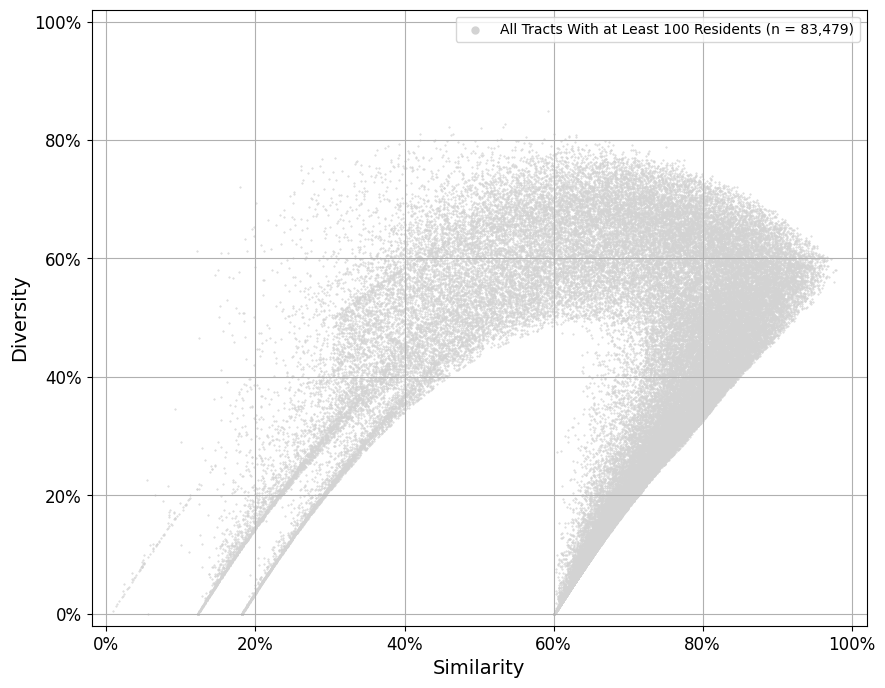

In [25]:
ax = scatter_all(df_tract)

## Colors in the Legs

It isn't immediately obvious what the legs of the plot are an what they represent.
But if we color in some of the most homogenous tracts in the country, where one
racial or ethnic group represents 80% or more of the population, we see something
interesting. Each leg consists of the tracts dominated by a different group.

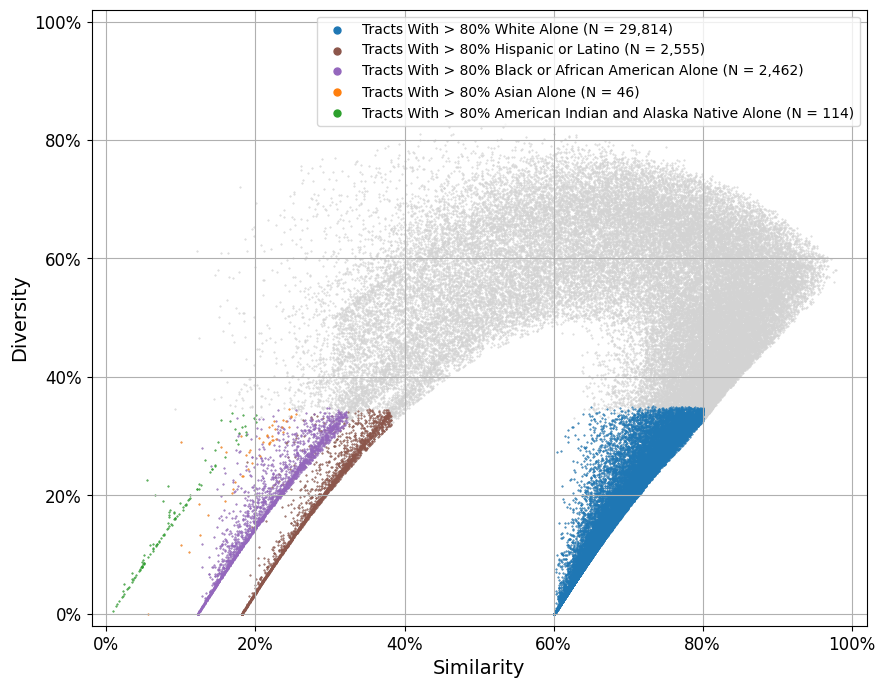

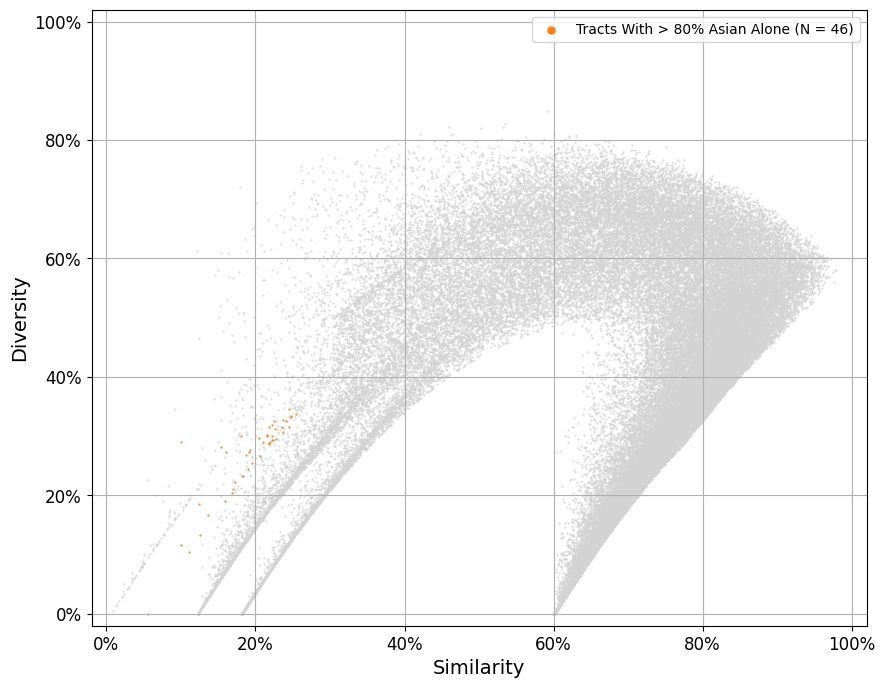

In [26]:
threshold = 0.8

graph_colors = [
    [
        (0, 'C0'),
        (-1, 'C5'),
        (1, 'C4'),
        (3, 'C1'),
        (2, 'C2'),
    ],
    [
        (3, 'C1'),
    ]
]

for colors in graph_colors:
    ax = scatter_all(df_tract, label=False)

    for ii, color in colors:
        df_over = df_tract[df_tract[f'frac_{leaves[ii]}'] > threshold]
        ax = df_over.plot.scatter(
            'similarity', 'diversity', s=0.2, c=color,
            label=(
                f'Tracts With > {threshold * 100:.0f}% {leaf_names[leaves[ii]]} '
                f'(n = {len(df_over.index):,.0f})'
            ).title().replace('Or', 'or').replace('And', 'and'),
            ax=ax,
        )

    legend = ax.legend()
    for handle in legend.legend_handles:
        handle._sizes = [25]

    ax.set_xlabel("Similarity", fontsize=14)
    ax.set_ylabel("Diversity", fontsize=14)

    ax.grid()

## Tips of the Legs

Let's look at the tips of the legs. Each one is a 100% or nearly
100% homogeneous, which leads to zero or near zero diversity.

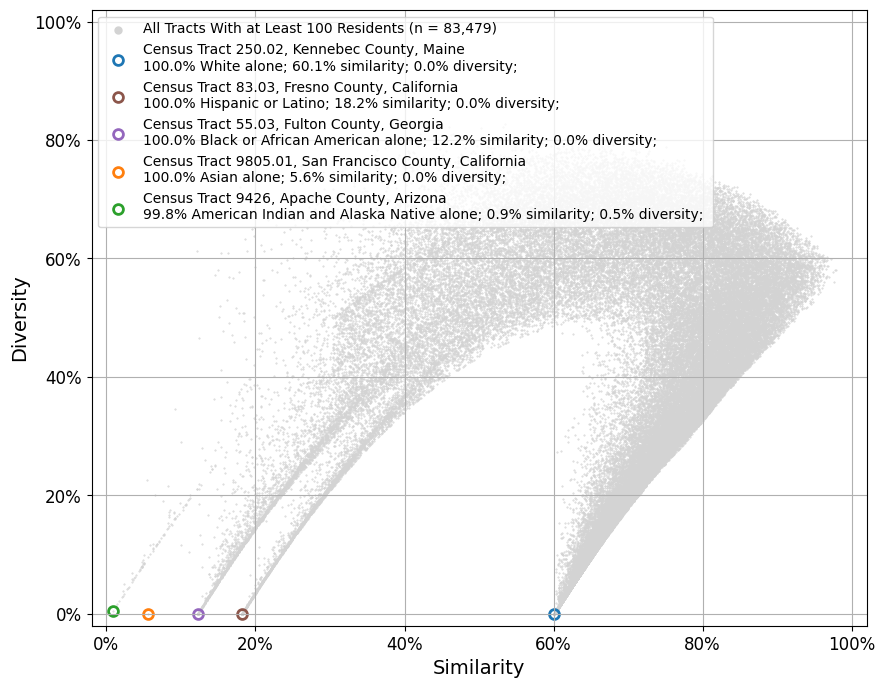

In [27]:
ax = scatter_all(df_tract)

for ii, color in graph_colors[0]:
    
    df_extreme = df_tract[df_tract['max_col'] == leaves[ii]].nsmallest(
        100, 'diversity'
    ).nsmallest(
        1, 'similarity'
    )

    frac = df_extreme[f'frac_{leaves[ii]}'].iloc[0]
    
    name = df_extreme['NAME'].iloc[0]
    name = (
        f'{name}\n'
        f'{100 * frac:.1f}% {leaf_names[leaves[ii]]}; '
        f'{100 * df_extreme["similarity"].iloc[0]:.1f}% similarity; '
        f'{100 * df_extreme["diversity"].iloc[0]:.1f}% diversity; '
    )
    
    df_extreme.plot.scatter(
        'similarity', 'diversity',
        s=50, c='#0000', edgecolor=color, linewidth=2,
        label=name,
        ax=ax
    )
    
ax.set_xlabel("Similarity", fontsize=14)
ax.set_ylabel("Diversity", fontsize=14)

ax.grid()

## Maximum Similarity and Others at Similar Diversity (58% Diversity Cut)

Next, consider the most representative point and a series of other points that
are very near the same diversity, but very different similarities.

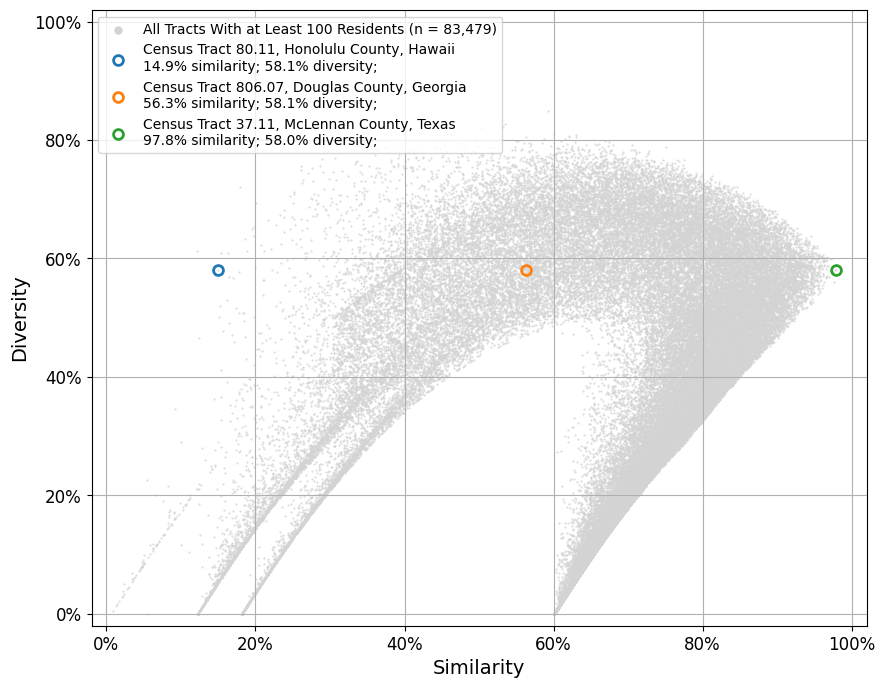

In [28]:
ax = scatter_all(df_tract)

df_max = df_tract.nlargest(1, 'similarity')

diversity = df_max["diversity"].iloc[0]

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'similarity')

rep = (df_max["similarity"].iloc[0] + df_min["similarity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['similarity'] > rep - 0.002) &
    (df_tract['similarity'] < rep + 0.002)
].nsmallest(1, 'similarity')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

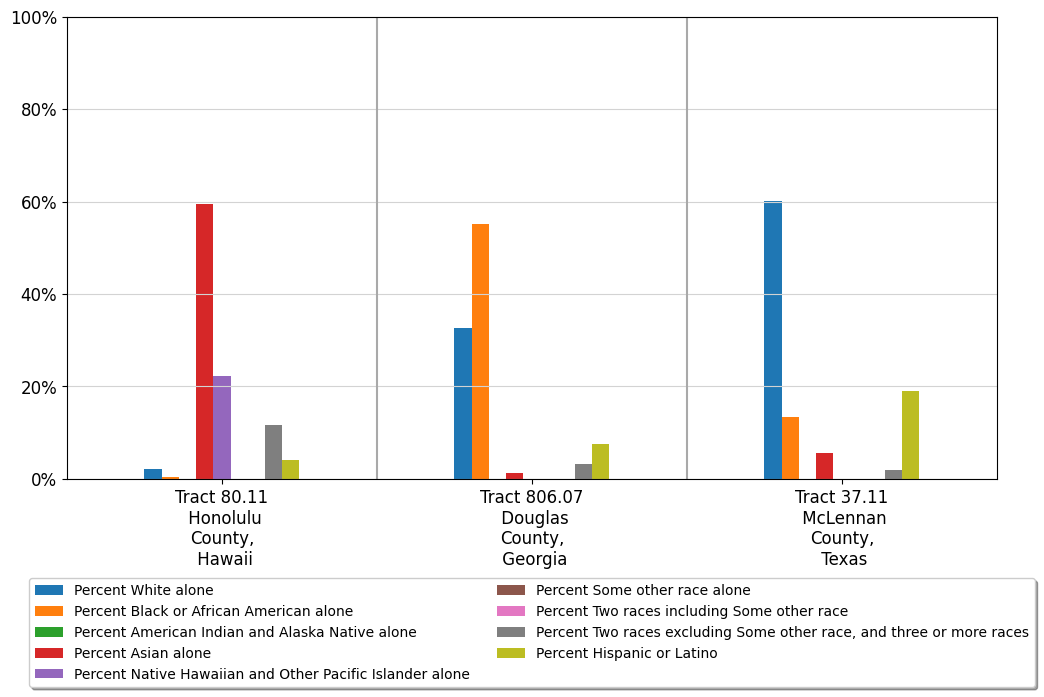

In [29]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 75% Diversity Cut

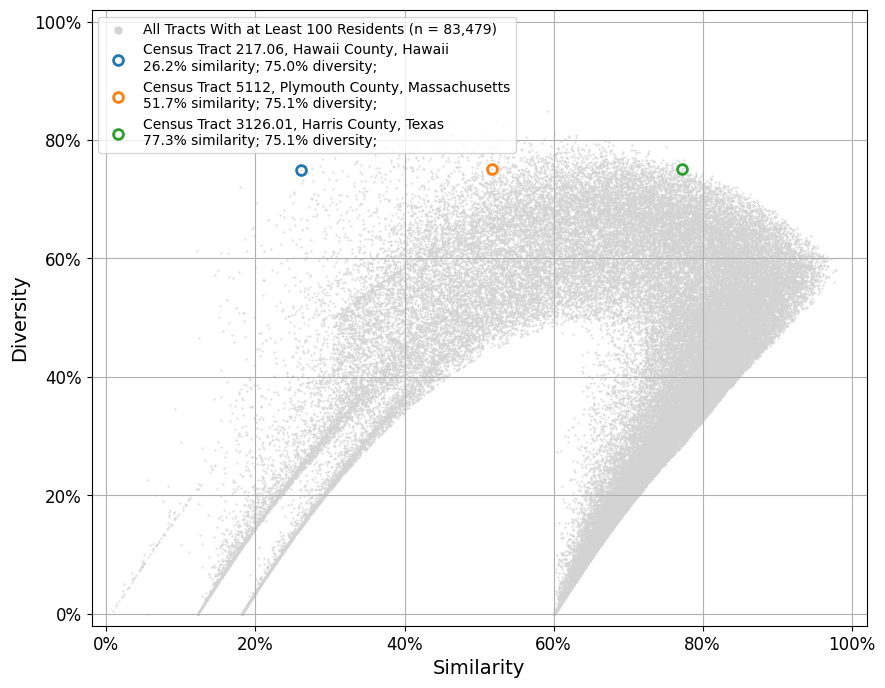

In [30]:
ax = scatter_all(df_tract)

diversity = 0.75

df_max = df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nlargest(1, 'similarity')

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'similarity')

rep = (df_max["similarity"].iloc[0] + df_min["similarity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['similarity'] > rep - 0.002) &
    (df_tract['similarity'] < rep + 0.002)
].nsmallest(1, 'similarity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

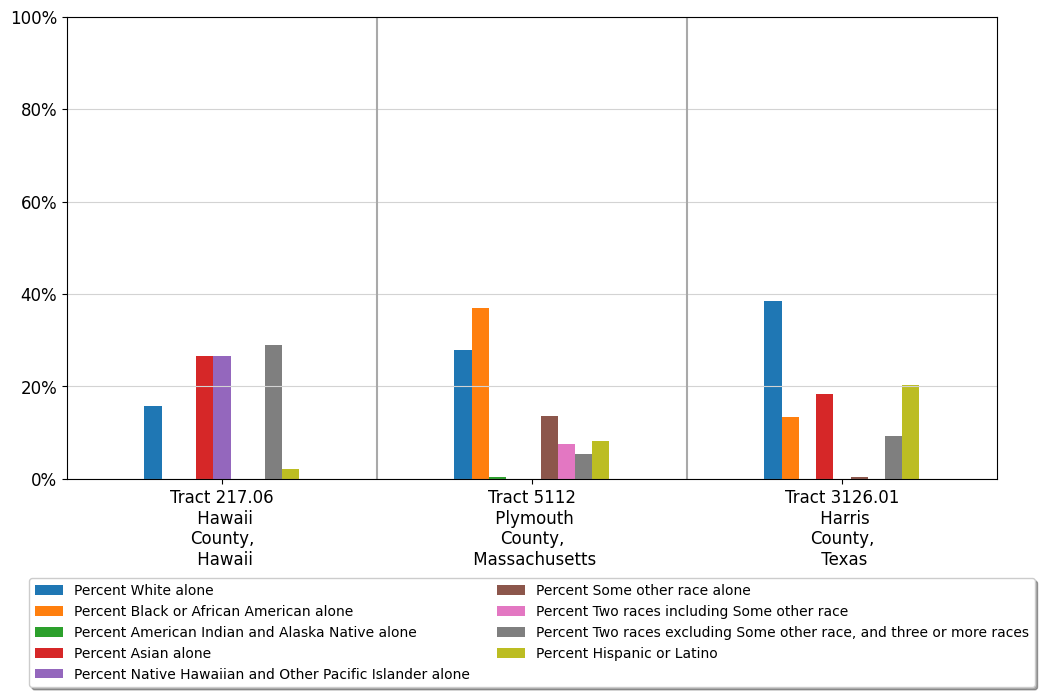

In [31]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 25% Diversity Cut

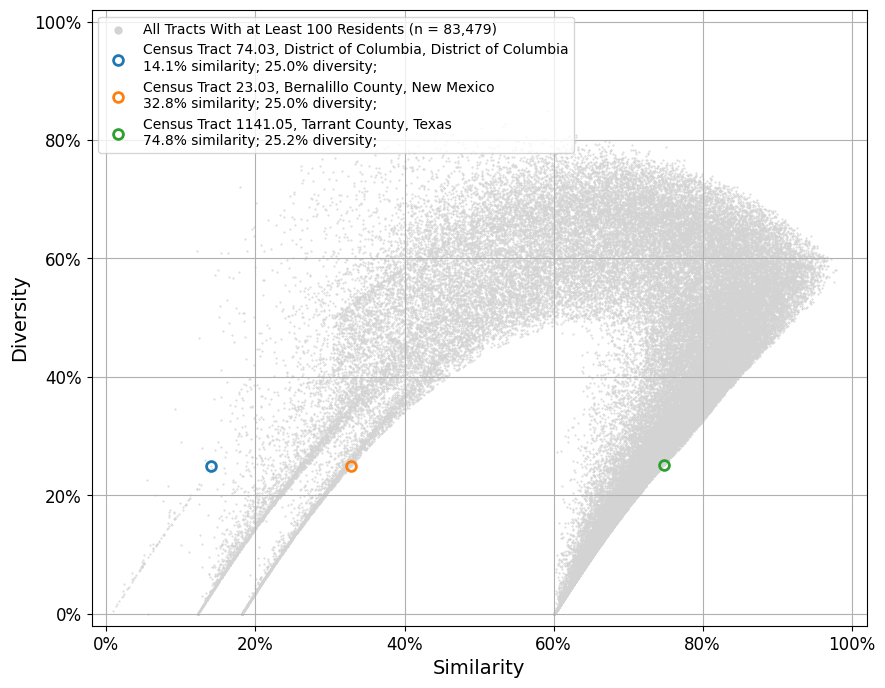

In [32]:
ax = scatter_all(df_tract)

diversity = 0.25

df_max = df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nlargest(1, 'similarity')

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'similarity')

rep = (df_max["similarity"].iloc[0] + df_min["similarity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['similarity'] > 0.3) &
    (df_tract['similarity'] < 0.4)
].nlargest(1, 'similarity')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

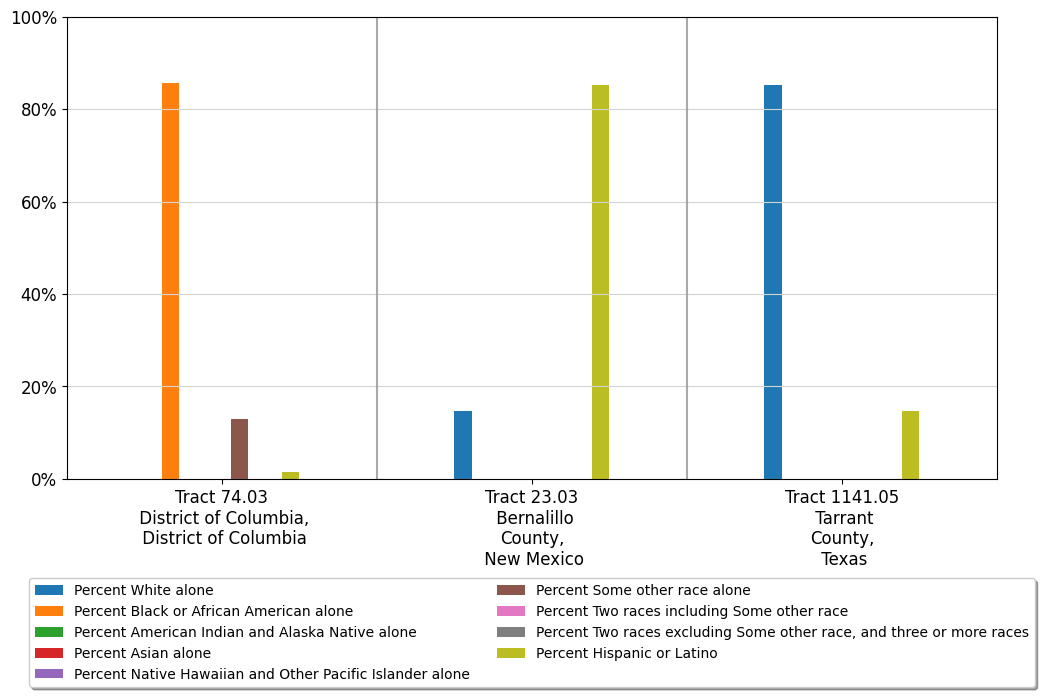

In [33]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 50% Diversity Cut

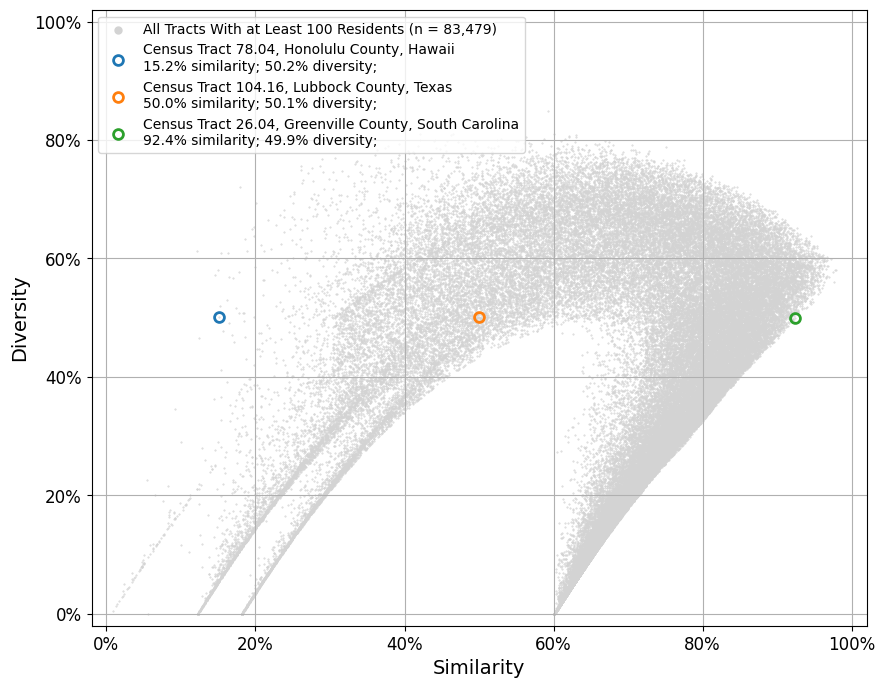

In [34]:
ax = scatter_all(df_tract)

diversity = 0.5

df_max = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nlargest(1, 'similarity')

df_min = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'similarity')

rep = (df_max["similarity"].iloc[0] + df_min["similarity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002) &
    (df_tract['similarity'] > 0.4) &
    (df_tract['similarity'] < 0.5)
].nlargest(1, 'similarity')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

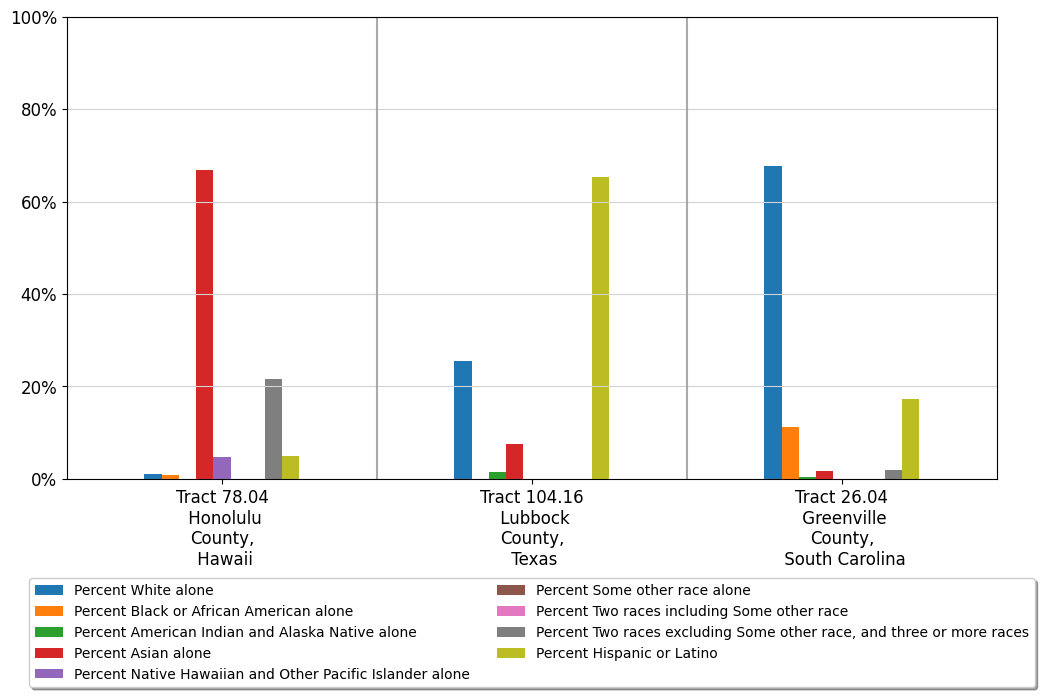

In [35]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## Tip of the White Leg and Others at Similar Similarity (60% Similarity Cut)

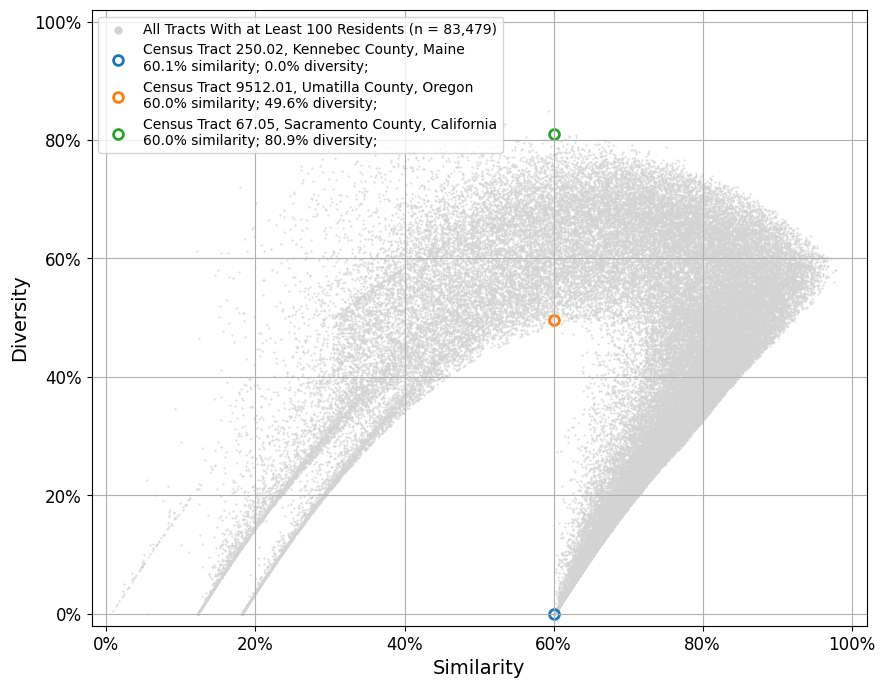

In [36]:
ax = scatter_all(df_tract)

df_min = df_tract[df_tract['max_col'] == leaves[0]].nsmallest(
    1, 'diversity'
)

similarity = df_min['similarity'].iloc[0]

df_max = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nlargest(1, 'diversity')

df_mid = df_tract[
    (df_tract['diversity'] > 0.4) &
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nsmallest(1, 'diversity')

plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

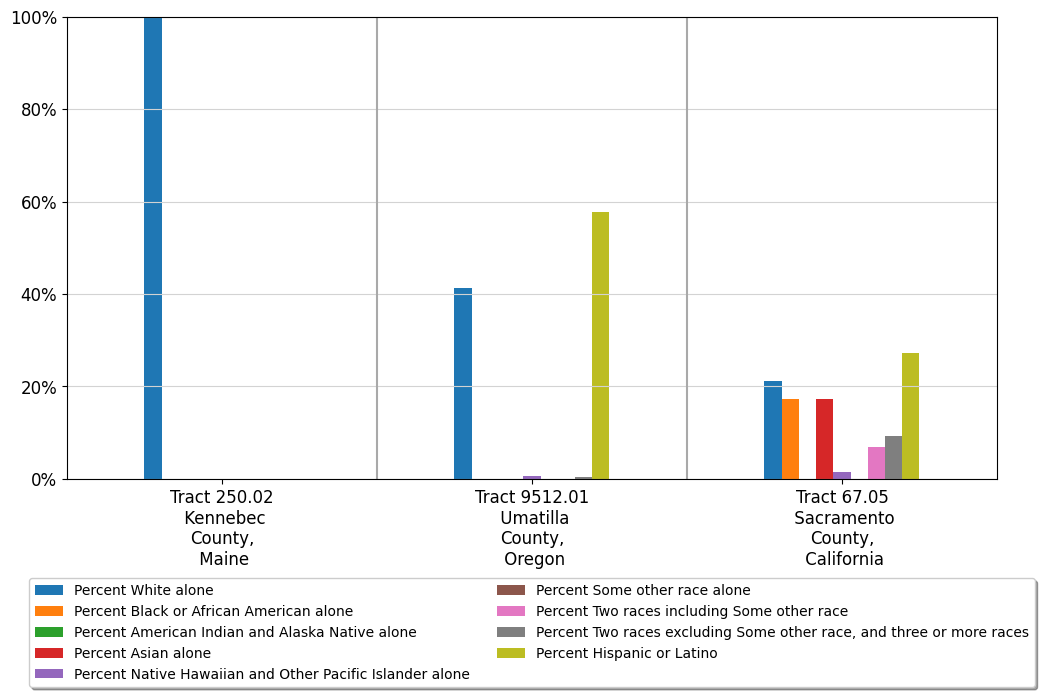

In [37]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 75% Similarity Cut

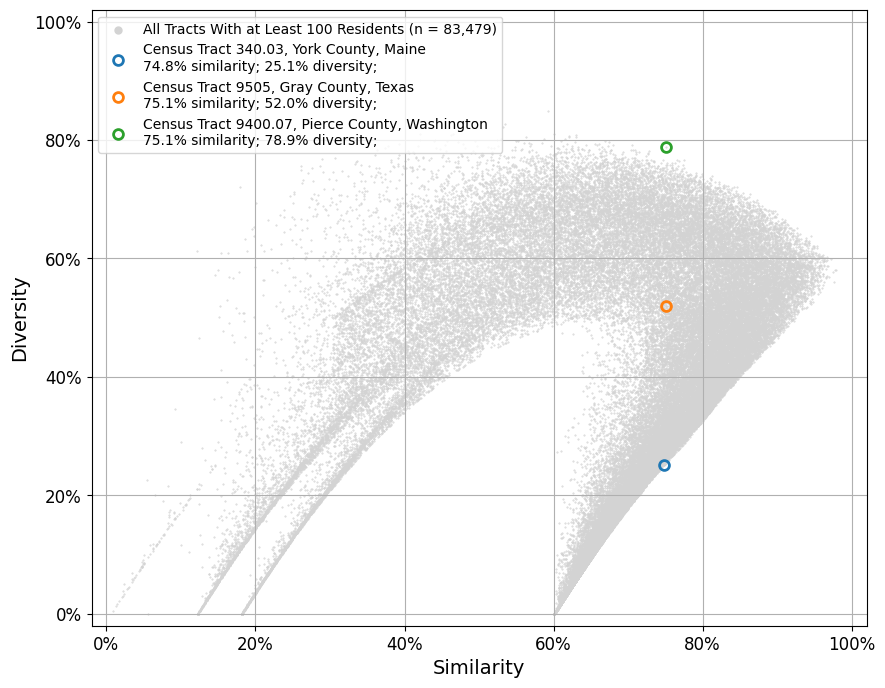

In [38]:
ax = scatter_all(df_tract)

similarity = 0.75

df_max = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nlargest(1, 'diversity')

df_min = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nsmallest(1, 'diversity')

diversity = (df_max["diversity"].iloc[0] + df_min["diversity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002) &
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'diversity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

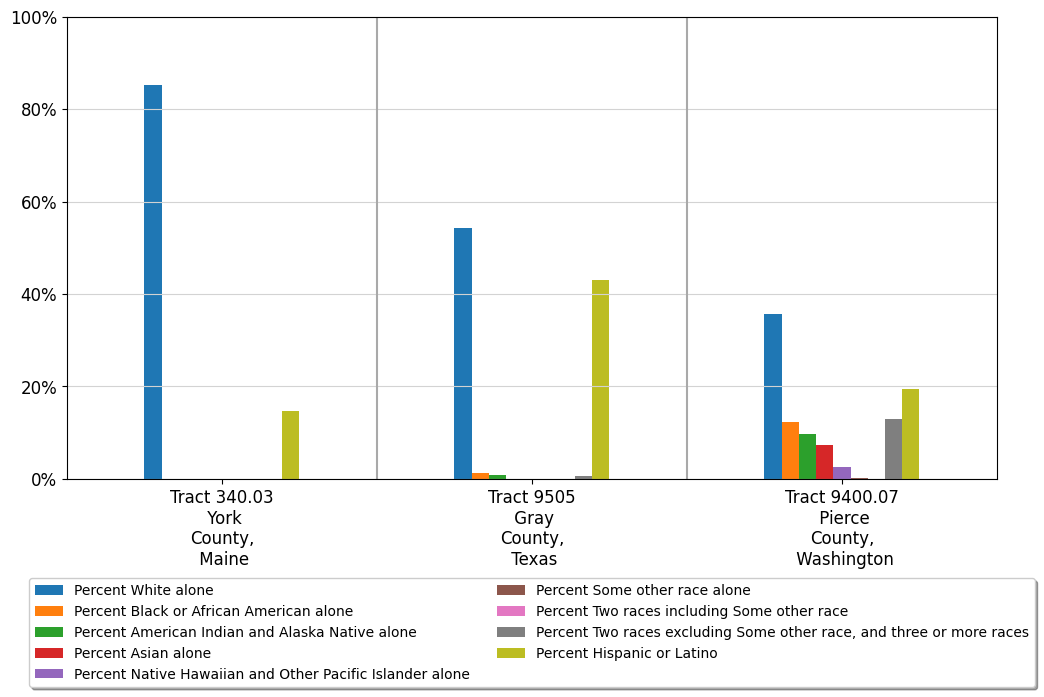

In [39]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 50% Similarity Cut

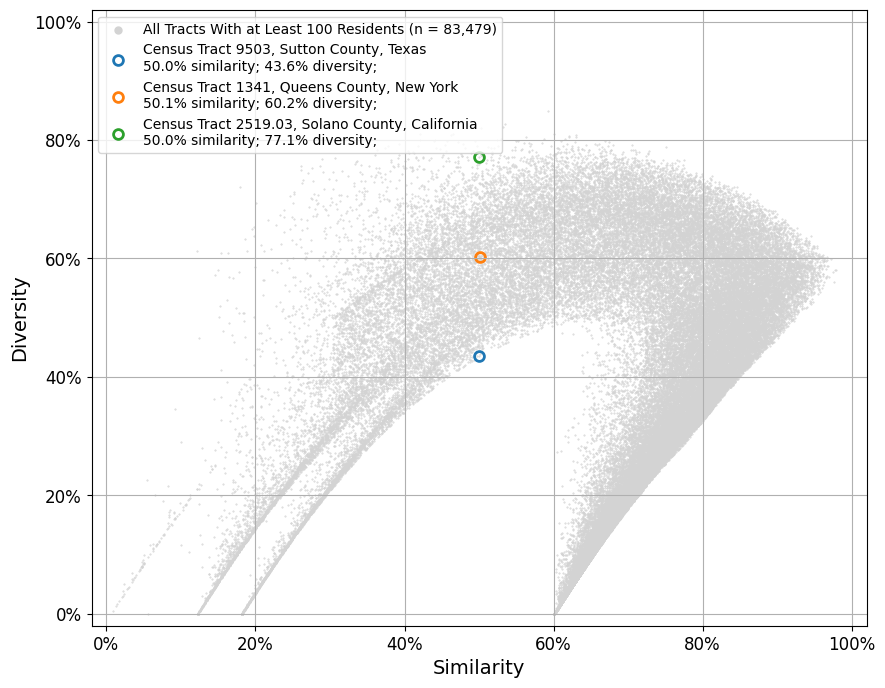

In [40]:
ax = scatter_all(df_tract)

similarity = 0.5

df_max = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nlargest(1, 'diversity')

df_min = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nsmallest(1, 'diversity')

diversity = (df_max["diversity"].iloc[0] + df_min["diversity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002) &
    (df_tract['diversity'] > diversity - 0.002) &
    (df_tract['diversity'] < diversity + 0.002)
].nsmallest(1, 'diversity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

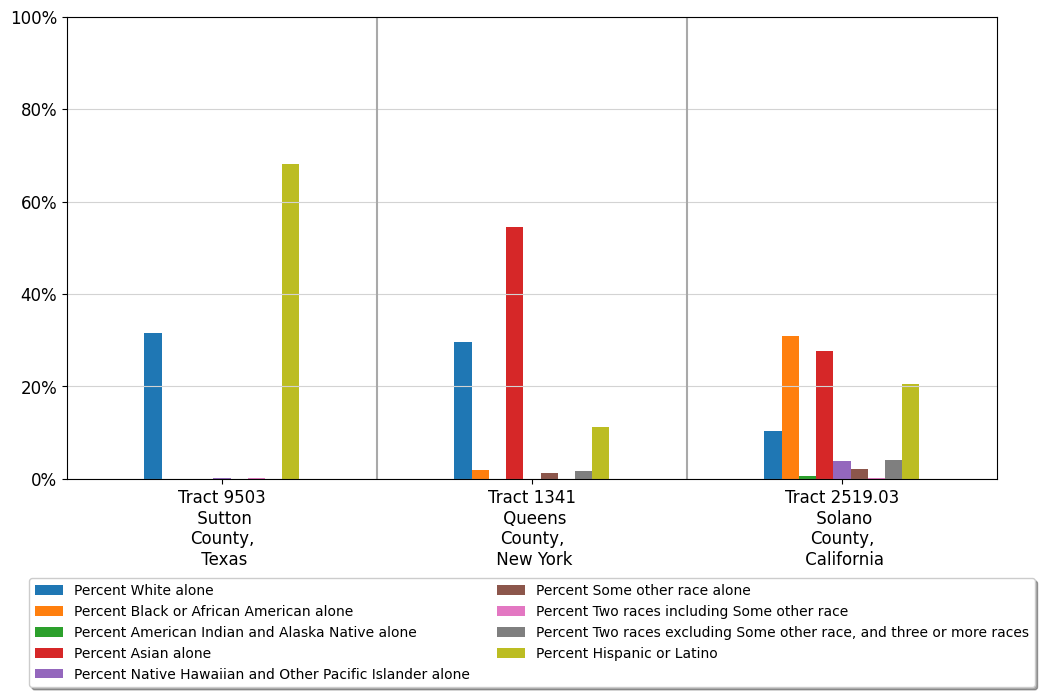

In [41]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## 25% Similarity Cut

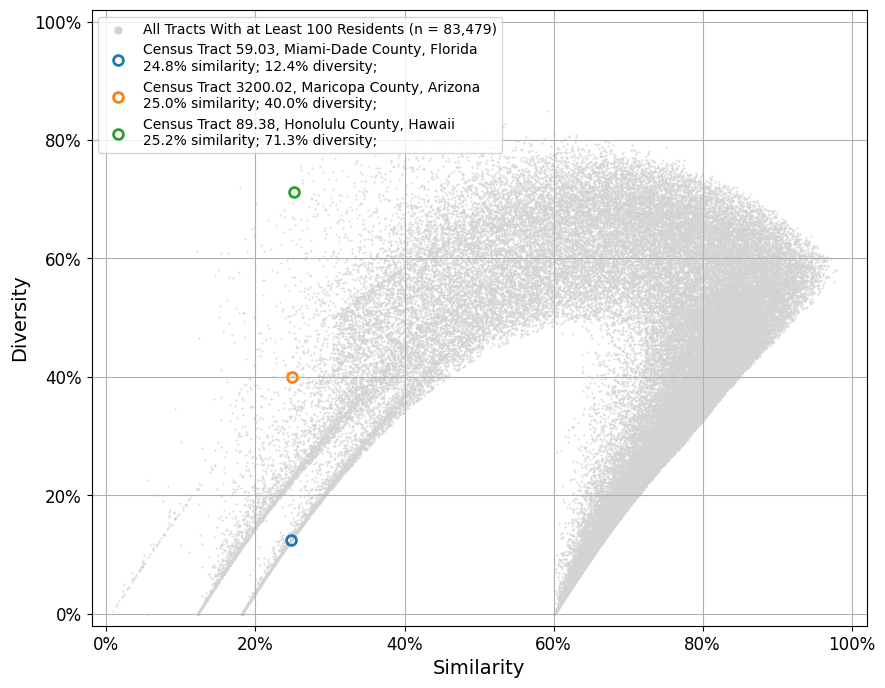

In [42]:
ax = scatter_all(df_tract)

similarity = 0.25

df_max = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nlargest(1, 'diversity')

df_min = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002)
].nsmallest(1, 'diversity')

diversity = (df_max["diversity"].iloc[0] + df_min["diversity"].iloc[0]) / 2

df_mid = df_tract[
    (df_tract['similarity'] > similarity - 0.002) &
    (df_tract['similarity'] < similarity + 0.002) &
    (df_tract['diversity'] > diversity - 0.02) &
    (df_tract['diversity'] < diversity + 0.02)
].nsmallest(1, 'diversity')


plot_hilight(df_min, ax, 'C0')
plot_hilight(df_mid, ax, 'C1')
plot_hilight(df_max, ax, 'C2')

ax.grid()

<Axes: >

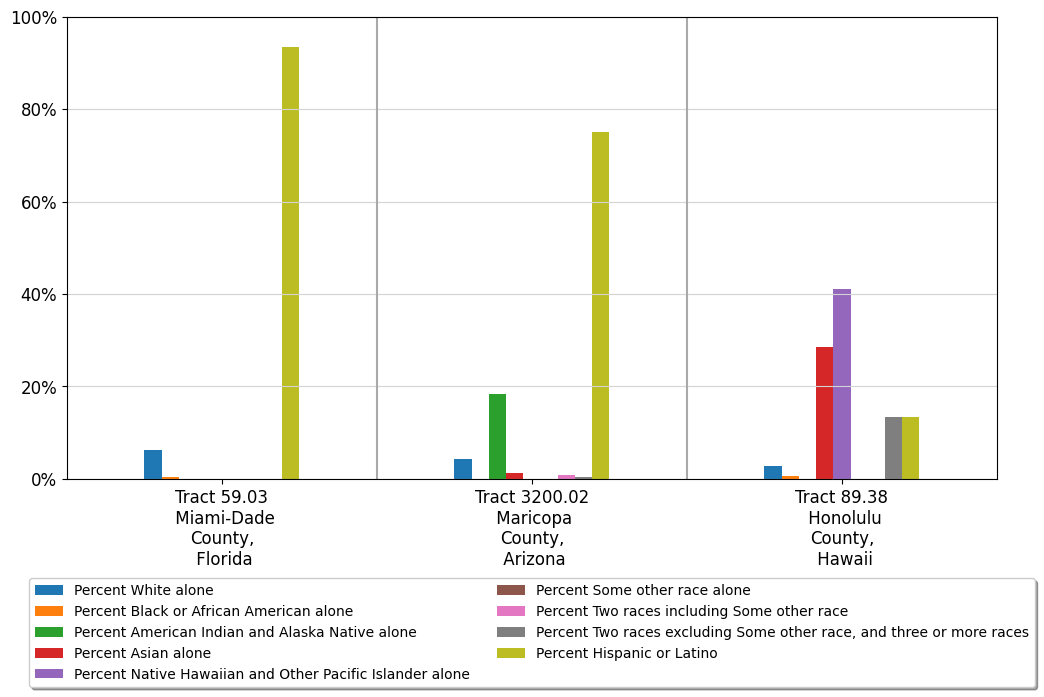

In [43]:
df_selected_points = pd.concat([df_min, df_mid, df_max])
plot_bar_selected(df_selected_points)

## State-Level Samples

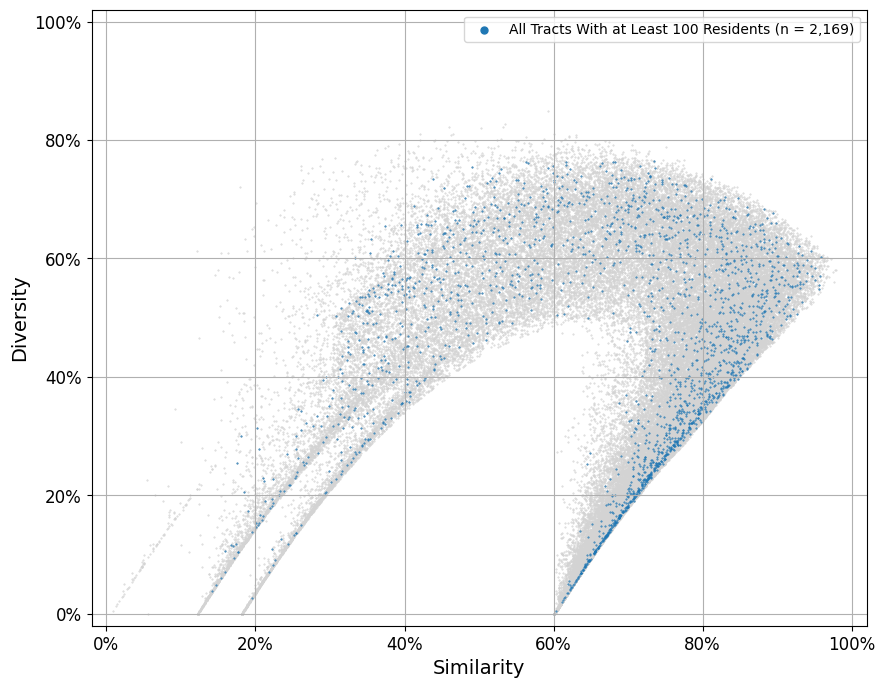

In [44]:
ax = scatter_all(df_tract, label=False)
ax = scatter_all(df_tract[df_tract['STATE'] == states.NJ], color='C0', ax=ax)